# Part 1 - Data Prep

**For those using Google Colab** _A restart may be needed to properly load the modules needed for PANNA._

In this exercise, we will go through the same workflow as done in the first two tutorials, but we will train potentials on a larger dataset of Carbon structures.

The notebook is divided into the following parts:

1. Data Preparation _(We're not starting from `.xml` files.)_ - Convert the `.example` files to TensorFlow Records (`.tfr`) to be read by PANNA using `gvect_calculator.py` and `tfr_packer.py`, respectively.

2. Training and Validation - Train and validate your neural network potential using `train.py` and `evaluate.py`. You can monitor its performance by plotting the learning curve and the parity plot.

3. Tune the model - See if we need to tune our training parameters if our first attempts to train the network do not look satisfactory.

Like the first two tutorials, we have to load the necessary packages below. Make sure you uncomment the right section depending on whether you're using Colab or a local jupyter notebook copy. This part assumes that you have already installed the prerequisites of PANNA. You can follow the directions in the `README.md` if you haven't done so yet.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

## 1a - Converting `.example` -> `.gvector`

We will be using a dataset of 1000 diamond-like structures, with 20% set aside for validation while the remaining is used for training. Unpack the `datasets/diamond_1000.zip` file and you will see that the training and validation subdirectories have been split already.

Now we convert the `.example` files to gvectors. Use `gvect_calculator.py` and create your configuration file for running the code. If you are using the `.ini` file from the tutorial, you can keep most of the gvector parameters constant and just change the directories and the species.

### Training set

In [ ]:
!python 'panna-master/src/panna/gvect_calculator.py' --config 'input_files/gvect_dia1000_train.ini'

### Validation set

Unlike `tutorial_1_data_prep.ipynb`, this time we will obtain the gvectors for the validation set explicitly. To avoid confusion, you may use a separate `.ini` file for this.

In [ ]:
!python 'panna-master/src/panna/gvect_calculator.py' --config 'input_files/gvect_dia1000_val.ini'

## 1b - Packing to `.tfr`

As previously, we run `tfr_packer.py` for training and validation sets separately.

In [ ]:
# Training
!python 'panna-master/src/panna/tfr_packer.py' --config 'input_files/tfr_dia1000_train.ini'

In [ ]:
# Validation
!python 'panna-master/src/panna/tfr_packer.py' --config 'input_files/tfr_dia1000_val.ini'

# Part 2 - Training and validation

Once the data has been prepared for both the training and validation sets, we now 
* modify the `.ini` file from the tutorial to appropriate values for our monoatomic Carbon dataset. This can mean changing the directories, offset values, gsize, etc., and
* perform a quick trial training to see if (a) there are no errors in input/outputs and (b) we are adequately training.


## 2a - Checking for configuration file consistency

Since you have to define the `g_size` parameter in the `[DEFAULT_NETWORK]` section of your configuration file, it would not hurt to check what is the correct value as is done in `tutorial_1_data_prep.ipynb`.


In [16]:
units = 'angstrom'
# radial
rc_rad = 4.6
rs0_rad = 0
rsn_rad = 16
rsst_rad = (rc_rad - rs0_rad) / rsn_rad
rs_rad = np.arange(rs0_rad, rc_rad, rsst_rad)
eta_rad = 16
eta_rad = np.tile(np.asarray(eta_rad), len(rs_rad))

# angular
thetasn = 8
step_theta = np.pi / thetasn
thetas = np.arange(0, np.pi, step_theta) + .5 * step_theta
zeta = 50
zeta = np.tile(np.asarray(zeta), len(thetas))

# radial_angular components
rc_ang = 3.1
rs0_ang = 0
rsn_ang = 4
rsst_ang = (rc_ang - rs0_ang) / rsn_ang
rs_ang = np.arange(rs0_ang, rc_ang, rsst_ang)
eta_ang = 6.0
eta_ang = np.tile(np.asarray(eta_ang), len(rs_ang))

In [17]:
from panna.gvector import GvectmBP
species = 'C'
gvect_func = GvectmBP(species=species)
nsp = len(species.split(','))

gvect_func.units = units
gvect_func.update_parameter('Rc_rad', rc_rad)
gvect_func.update_parameter('Rs_rad', rs_rad)
gvect_func.update_parameter('eta_rad', eta_rad)
gvect_func.update_parameter('Thetas', thetas)
gvect_func.update_parameter('zeta', zeta)
gvect_func.update_parameter('Rc_ang', rc_ang)
gvect_func.update_parameter('Rs_ang', rs_ang)
gvect_func.update_parameter('eta_ang', eta_ang)

print("Number of species is: {}".format(nsp))

print("Size of the radial part is: {}".format(len(rs_rad) * nsp))

print("Size of the angular part \
for each species permutation is: {}".format(len(thetas)*len(rs_ang)))

print("There are {} 3-body species permutations \
hence the total size of the angularpart is: {} ".format((nsp*nsp+nsp)//2 , len(thetas)*len(rs_ang) *(nsp*nsp+nsp)//2 ))

print("The total size of the G-vector with these parameters is: {}".
        format(gvect_func.gsize))

2025-01-18 23:40:10.674711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-18 23:40:10.709829: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-18 23:40:10.710412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 23:40:13.094914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of species is: 1
Size of the radial part is: 16
Size of the angular part for each species permutation is: 32
There are 1 3-body species permutations hence the total size of the angularpart is: 32 
The total size of the G-vector with these parameters is: 48


## 2b - Training and validation

A sample `train.ini` file is shown for you below. Keep in mind that `gsize` changes according to how you set up your gvectors.

In [2]:
!cat 'input_files/train_dia1000_trial.ini'

[IO_INFORMATION]
data_dir = ./tfr/diamond_1000/train
train_dir = ./train_diamond1000
log_frequency = 100
save_checkpoint_steps = 1000

[DATA_INFORMATION]
atomic_sequence = C
output_offset = -253.67376683573406

[TRAINING_PARAMETERS]
batch_size = 50
learning_rate = 0.001
steps_per_epoch = 1000
max_epochs = 10

[DEFAULT_NETWORK]
g_size = 48
architecture = 128:32:1
trainable = 1:1:1

[VALIDATION_OPTIONS]
data_dir = ./tfr/diamond_1000/val

In [3]:
# Training
!python 'panna-master/src/panna/train.py' --config 'input_files/train_dia1000_trial.ini'

2025-01-19 01:17:44.648324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:17:44.686641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:17:44.687014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:17:46.607282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

Then we validate the model only at the last step of training.

In [ ]:
!cat 'input_files/val_dia1000_trial.ini'

[IO_INFORMATION]
data_dir = ./tfr/diamond_1000/val
train_ini = ./input_files/train_dia1000_trial.ini
networks_dir = ./train_diamond1000/_models
eval_dir = ./val_diamond1000_trial

[VALIDATION_OPTIONS]
single_step = True 



In [5]:
# Validation
!python 'panna-master/src/panna/evaluate.py' --config 'input_files/val_dia1000_trial.ini'

2025-01-19 01:18:53.470174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:18:53.508499: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:18:53.508880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:18:55.340825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

## 2c - Visualization

We can look at the training curve and the parity plot to see (a) if we have trained the potential well and (b) how well it performs with the validation set.

/tmp/ipykernel_919297/1600377509.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_trial = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)


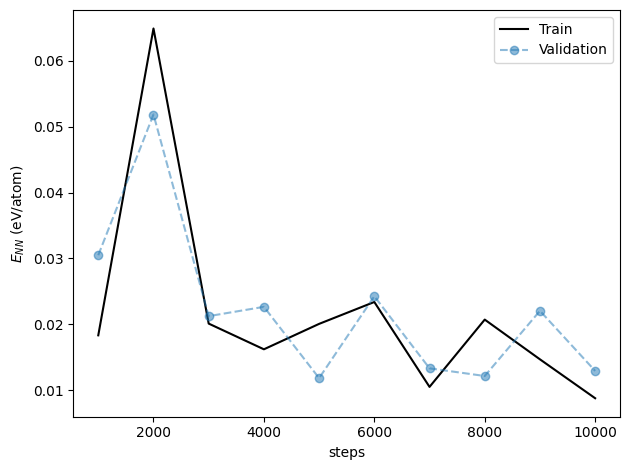

In [9]:
df_trial = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)
plt.plot(df_trial['tot_st'], df_trial['MAE/at'], color='k', label='Train')
plt.plot(df_trial['tot_st'], df_trial['val_MAE/at'], 'o--', label='Validation', alpha=0.5)
plt.ylabel(r'$E_{NN}$ (eV/atom)')
plt.xlabel('steps')
plt.legend()
plt.tight_layout()

(-254.0, -253.0)

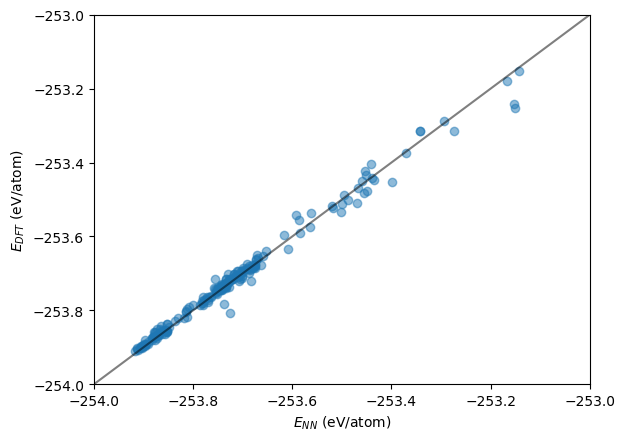

In [ ]:
dv_trial = pd.read_csv('val_diamond1000_trial/epoch_10_step_10000.dat', sep='\s+')
plt.scatter(dv_trial['e_ref']/dv_trial['n_atoms'], dv_trial['e_nn']/dv_trial['n_atoms'], alpha=0.5)
plt.ylabel(r'$E_{DFT}$ (eV/atom)')
plt.xlabel(r'$E_{NN}$ (eV/atom)')
lims = [min(-700, -200), max(-700, -200)]
plt.plot(lims, lims, color='k', alpha=0.5)
plt.xlim(-254,-252.8)
plt.ylim(-254,-252.8)

# Part 3 - Improving runs

If the training curve of our trial run looks like it has not been trained well (i.e. training errors have not saturated), some ways that can improve the model are:

* restarting training from an existing checkpoint 
* tuning the training parameters (also called hyperparameters, which are configuration variables called by the user)
* modifying the gvectors/desriptors (which we will not do for this exercise, but we welcome your experiments)

<span style="color:orange; font-weight:bold">NOTE:</span> You may not need to run any of these if you have managed to train well on your trial. It is not required to run all of them, and we leave the freedom to you on how to improve your network.

## 3a - Restarting your training

We saw in the [visualization](#2c---Visualization) exercise that the training error has not gone down a lot yet. Before we play around with the parameters, it may be good to see what happens if we continue training, as we did only have 10 epochs from the trial run. Let us extend the training to 100 epochs. To do so, we look at the sample `train.ini` below, and then continue training.

In [15]:
!cat 'input_files/train_dia1000_restart.ini'

[IO_INFORMATION]
data_dir = ./tfr/diamond_1000/train
train_dir = ./train_diamond1000
log_frequency = 100
save_checkpoint_steps = 1000
restart_mode=continue_from_last_ckpt

[DATA_INFORMATION]
atomic_sequence = C
output_offset = -253.67376683573406

[TRAINING_PARAMETERS]
batch_size = 50
learning_rate = 0.001
steps_per_epoch = 1000
max_epochs = 200

[DEFAULT_NETWORK]
g_size = 48
architecture = 128:32:1
trainable = 1:1:1

[VALIDATION_OPTIONS]
data_dir = ./tfr/diamond_1000/val

In [16]:
# Training
!python 'panna-master/src/panna/train.py' --config 'input_files/train_dia1000_restart.ini'

2025-01-19 01:22:18.464383: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:22:18.503768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:22:18.504127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:22:20.401633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

### Restarted run: learning rate

/tmp/ipykernel_919297/1243540725.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_restart = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)


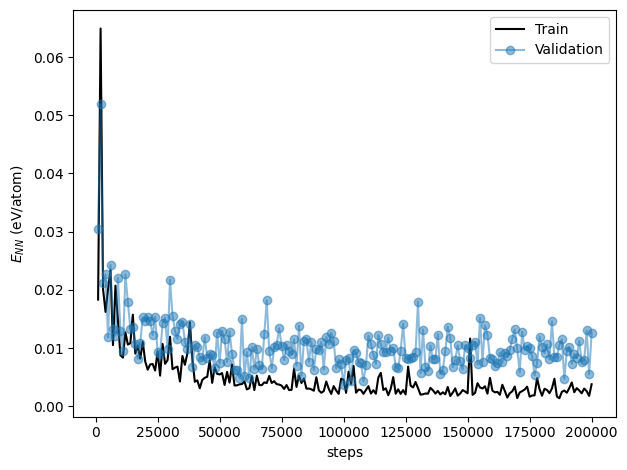

In [ ]:
df_restart = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)
plt.plot(df_restart['tot_st'], df_restart['MAE/at'], color='k', label='Train')
plt.plot(df_restart['tot_st'], df_restart['val_MAE/at'],'o-', label='Validation', alpha=0.5)
plt.ylabel(r'$E_{NN}$ (eV/atom)')
plt.xlabel('steps')
plt.legend()
plt.tight_layout()

### Restarted run: parity plot

In [18]:
# Validation restart
!python 'panna-master/src/panna/evaluate.py' --config 'input_files/val_dia1000_restart.ini'

2025-01-19 01:40:59.274335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:40:59.310847: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:40:59.311244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:41:01.423322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

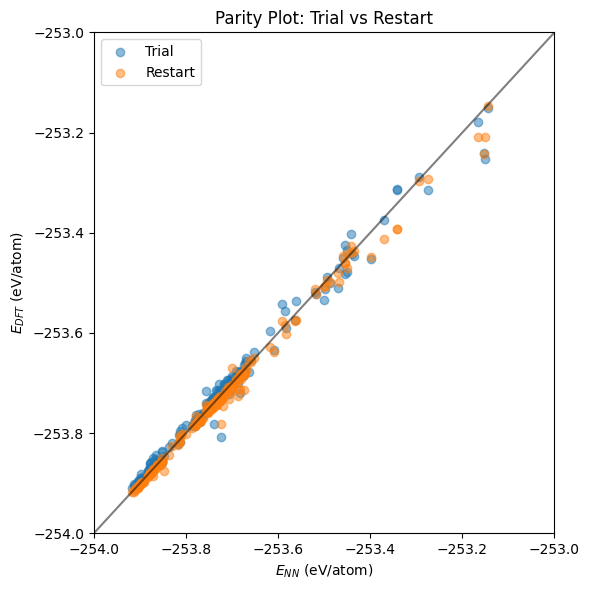

In [ ]:
dv_restart = pd.read_csv('val_diamond1000_restart/epoch_100_step_100000.dat', sep='\s+')

fig, ax = plt.subplots(figsize=(6,6))

# Trial parity plot
ax.scatter(dv_trial['e_ref']/dv_trial['n_atoms'], dv_trial['e_nn']/dv_trial['n_atoms'], label='Trial', alpha=0.5)

# Restart parity plot
ax.scatter(dv_restart['e_ref']/dv_restart['n_atoms'], dv_restart['e_nn']/dv_restart['n_atoms'], label='Restart', alpha=0.5)

ax.set_ylabel(r'$E_{DFT}$ (eV/atom)')
ax.set_xlabel(r'$E_{NN}$ (eV/atom)')
lims = [min(-700, -200), max(-700, -200)]
ax.plot(lims, lims, color='k', alpha=0.5)
ax.set_xlim(-254, -252.8)
ax.set_ylim(-254, -252.8)
ax.legend()
ax.set_title('Parity Plot: Trial vs Restart')
plt.tight_layout()

## 3b - Tuning hyperparameters

If you are convinced that prolonging the training will not improve the errors anymore, you may consider adjusting the training parameters/hyperparameters.

You can find them under the `[DATA_INFORMATION]` header in your configuration file. Below are some examples (full set of parameters [here](https://pannadevs.gitlab.io/pannadoc/inputs/train.html#training-parameters)). 

* `batch_size` - number of examples that are looked at during an epoch of training
* `learning_rate` - the 'step size' per iteration in parameter space
* `steps_per_epoch` - how many iterations are done for the chosen batch
* `max_epochs` - how many batches are used for training, basically extending the run

A common hyperparameter to vary once the training error converges is the `learning_rate`. Once the model approaches the neighborhood of a minimum in parameter space, the chosen 'step size' at the start may be too large and we end up skipping over our target. To reach these minima, we can **quench**, or change the `learning_rate` (usually by a few orders of magnitude). In our case, the training error in [the learning curve of the restarted run](#Restarted-run:-learning-rate) suggests that we should decrease the learning rate. 

Answer the following questions:

1. Did quenching the learning rate improve the training curve and parity plots? Why or why not? 
2. What changes in the learning curve when the other hyperparameters are tuned (for example, if batch size is too small or too large)?

In [21]:
!cat 'input_files/train_dia1000_tuned.ini'

[IO_INFORMATION]
data_dir = ./tfr/diamond_1000/train
train_dir = ./train_diamond1000
log_frequency = 100
save_checkpoint_steps = 1000
restart_mode=continue_from_last_ckpt

[DATA_INFORMATION]
atomic_sequence = C
output_offset = -253.67376683573406

[TRAINING_PARAMETERS]
batch_size = 50
learning_rate = 1e-6
steps_per_epoch = 1000
max_epochs = 300

[DEFAULT_NETWORK]
g_size = 48
architecture = 128:32:1
trainable = 1:1:1

[VALIDATION_OPTIONS]
data_dir = ./tfr/diamond_1000/val

In [22]:
# Training
!python 'panna-master/src/panna/train.py' --config 'input_files/train_dia1000_tuned.ini'

2025-01-19 01:42:10.913907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:42:10.950188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:42:10.950598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:42:12.849214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

/tmp/ipykernel_919297/2630613710.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_tuned = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)


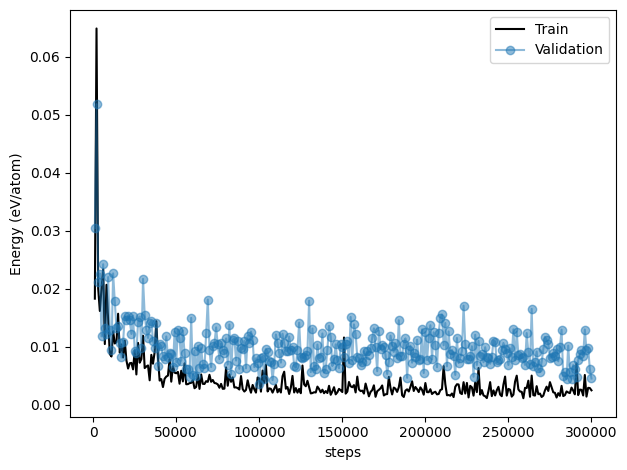

In [23]:
df_tuned = pd.read_csv('train_diamond1000/metrics.dat', delim_whitespace=True)
plt.plot(df_tuned['tot_st'], df_tuned['MAE/at'], color='k', label='Train')
plt.plot(df_tuned['tot_st'], df_tuned['val_MAE/at'],'o-', label='Validation',alpha=0.5)
plt.ylabel('Energy (eV/atom)')
plt.xlabel('steps')
plt.legend()
plt.tight_layout()

In [24]:
# Validation
!python 'panna-master/src/panna/evaluate.py' --config 'input_files/val_dia1000_tuned.ini'

2025-01-19 01:47:27.469360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:47:27.507038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 01:47:27.507459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 01:47:29.409297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO - 
    ____   _    _   _ _   _    _           
   |  _ \ / \  | \ | | \ | |  / \     
   | |_) / _ \ |  \| |  \| | / _ \     
   |  __/ ___ \| |\  | |\  |/ ___ \    
   |_| /_/   \_\_| \_|_| \_/_/   \_\ 

 Properties from Artificial Neural Network Architectures

INFO - reading input_fil

/tmp/ipykernel_919297/468860261.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dv_tuned = pd.read_csv('val_diamond1000_tuned/epoch_300_step_300000.dat', delim_whitespace=True)


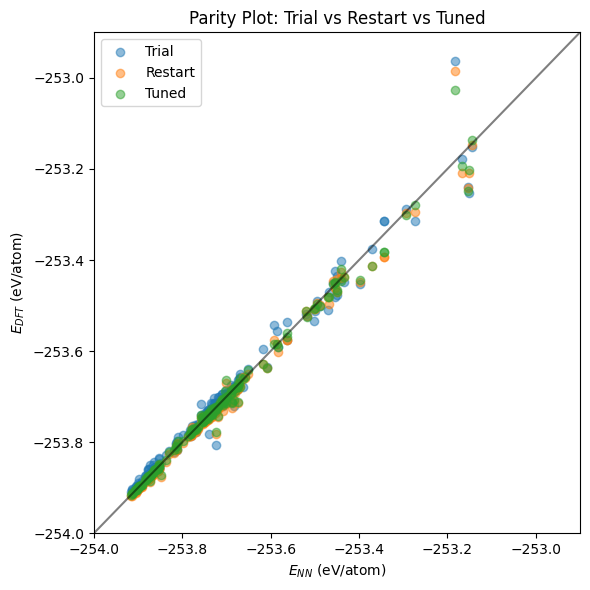

In [29]:
dv_tuned = pd.read_csv('val_diamond1000_tuned/epoch_300_step_300000.dat', delim_whitespace=True)

fig, ax = plt.subplots(figsize=(6,6))

# Trial parity plot
ax.scatter(dv_trial['e_ref']/dv_trial['n_atoms'], dv_trial['e_nn']/dv_trial['n_atoms'], label='Trial', alpha=0.5)

# Restart parity plot
ax.scatter(dv_restart['e_ref']/dv_restart['n_atoms'], dv_restart['e_nn']/dv_restart['n_atoms'], label='Restart', alpha=0.5)

# Tuned parity plot
ax.scatter(dv_tuned['e_ref']/dv_tuned['n_atoms'], dv_tuned['e_nn']/dv_tuned['n_atoms'], label='Tuned', alpha=0.5)

ax.set_ylabel(r'$E_{DFT}$ (eV/atom)')
ax.set_xlabel(r'$E_{NN}$ (eV/atom)')
lims = [min(-700, -200), max(-700, -200)]
ax.plot(lims, lims, color='k', alpha=0.5)
ax.set_xlim(-254, -252.9)
ax.set_ylim(-254, -252.9)
ax.legend()
ax.set_title('Parity Plot: Trial vs Restart vs Tuned')

plt.tight_layout()